In [1]:
import pandas as pd
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:

import numpy as np
import re

import math
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession



# spark = SparkSession.builder.master("local[*]").getOrCreate()
conf = SparkConf()
sc = SparkContext(conf=conf)

## Import Data

In [3]:
# input the first labeled dataset
origin_Fake = pd.read_csv('Fake.csv')
origin_True = pd.read_csv('True.csv')
# print(origin_Fake.head())
# print(origin_True.head())

# keep the text features and generate the labels
origin_Fake['text'] = origin_Fake.apply(lambda row: row['title']+" "+row['text'], axis=1)
origin_True['text'] = origin_Fake.apply(lambda row: row[0]+row[1], axis=1)
origin_Fake['label'] = 0 # Fake
origin_True['label'] = 1 # True
label_data1 = pd.DataFrame(columns=['text', 'label'])
label_data1 = label_data1.append(origin_Fake[['text','label']])
label_data1 = label_data1.append(origin_True[['text','label']])

# remove null data
label_data1 = label_data1.dropna()
# print(label_data1.head())
print("# of records of the first text datasets:", len(label_data1))

# of records of the first text datasets: 44898


In [4]:
# input the second labeled dataset
origin_train = pd.read_csv('train.csv')
# origin_test = pd.read_csv('/content/drive/My Drive/CS5344/GP/test.csv') # No label
# origin_train = origin_train.append(origin_test)
# print(origin_train)

# keep the text features and remove null data
origin_train = origin_train[['title','text','class']]
origin_train = origin_train.dropna()
origin_train['text'] = origin_train.apply(lambda row: row['title']+" "+row['text'], axis=1)
origin_train = origin_train.replace({'Fake':0, 'Real':1})

origin_train = origin_train.rename(columns={'class':'label'})
label_data2 = origin_train[['text','label']]
# print(label_data2.head())
print("# of records of the second text datasets:", len(label_data2))

# of records of the second text datasets: 40000


In [5]:
# combine the labeled datasets together
label_data = label_data1.append(label_data2)
label_data['id'] = list(range(len(label_data))) 
label_data = label_data[['id','text','label']]
print(label_data.head())
print("# of records of the labeled text dataset:", len(label_data))

   id                                               text label
0   0   Donald Trump Sends Out Embarrassing New Year’...     0
1   1   Drunk Bragging Trump Staffer Started Russian ...     0
2   2   Sheriff David Clarke Becomes An Internet Joke...     0
3   3   Trump Is So Obsessed He Even Has Obama’s Name...     0
4   4   Pope Francis Just Called Out Donald Trump Dur...     0
# of records of the labeled text dataset: 84898


In [6]:
# input the unlabeled dataset
origin_main = pd.read_csv('fake_news_dataset.csv')
# print(origin_main.head())

# exclude other language
origin_main = origin_main[origin_main['language']=='english'] 


# keep the text features and remove null data
origin_main = origin_main[['uuid','title','text']]
origin_main = origin_main.rename(columns={'uuid':'id'})
origin_main = origin_main.dropna()
origin_main['text'] = origin_main.apply(lambda row: row['title']+" "+row['text'], axis=1)
main_data = origin_main[['id','text']]
# print(main_data['id'].unique()) # the id is unique

print("# of records of the main text dataset:", len(main_data))

# of records of the main text dataset: 11677


In [ ]:
main_data

In [7]:
# combine all datasets together
big_data = label_data.append(main_data)
big_data['id'] = list(range(len(big_data))) 
big_data = big_data[['id','text','label']]
big_data = big_data[big_data['label']!='February 5, 2017']
print(big_data.head())
print("# of records of the labeled text dataset:", len(big_data))

   id                                               text label
0   0   Donald Trump Sends Out Embarrassing New Year’...     0
1   1   Drunk Bragging Trump Staffer Started Russian ...     0
2   2   Sheriff David Clarke Becomes An Internet Joke...     0
3   3   Trump Is So Obsessed He Even Has Obama’s Name...     0
4   4   Pope Francis Just Called Out Donald Trump Dur...     0
# of records of the labeled text dataset: 96574


## Check Label balance

Text(0.5, 1.0, 'Labeled Data Histogram')

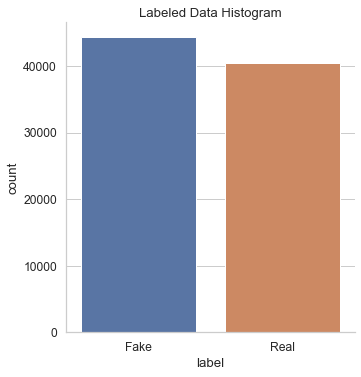

In [38]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.catplot(x="label", kind="count", data=big_data)
plt.xticks([0,1],['Fake','Real'])
plt.title('Labeled Data Histogram')

## Word Frequency 

In [8]:
# load the data into rdd format
false_data = big_data[big_data['label']==0]
big_data_rdd = sc.parallelize(false_data.values.tolist())


# transformed to lowercase
big_data_lower = big_data_rdd.map(lambda f: ((f[0], f[2]), str.lower(f[1])))

# print(label_data_lower.take(5))

# remove numbers
big_data_no_number = big_data_lower.map(lambda f: (f[0], re.sub(r'\d+', '', f[1])))
# print(label_data_no_number.take(5))

# remove punctuation and split it into words
big_data_words = big_data_no_number.map(lambda f: (f[0], re.split(r'[^\w]+',f[1])))
big_data_words = big_data_words.map(lambda f: (f[0], [i for i in f[1] if i != '']))
# print(label_data_words.take(5))



In [ ]:
print(big_data_words.take(5))

In [9]:
# remove stopwords
def remove_stopwords(words, lang='english'):
    from nltk.corpus import stopwords
    lang_stopwords = stopwords.words(lang)
    stopwords_removed = [w for w in words if w not in lang_stopwords]
    return stopwords_removed

big_data_no_stopwords = big_data_words.map(lambda f: (f[0], remove_stopwords(f[1])))

print(big_data_no_stopwords.take(5))

[((0, 0), ['donald', 'trump', 'sends', 'embarrassing', 'new', 'year', 'eve', 'message', 'disturbing', 'donald', 'trump', 'wish', 'americans', 'happy', 'new', 'year', 'leave', 'instead', 'give', 'shout', 'enemies', 'haters', 'dishonest', 'fake', 'news', 'media', 'former', 'reality', 'show', 'star', 'one', 'job', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'wish', 'friends', 'supporters', 'enemies', 'haters', 'even', 'dishonest', 'fake', 'news', 'media', 'happy', 'healthy', 'new', 'year', 'president', 'angry', 'pants', 'tweeted', 'great', 'year', 'america', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'wish', 'friends', 'supporters', 'enemies', 'haters', 'even', 'dishonest', 'fake', 'news', 'media', 'happy', 'healthy', 'new', 'year', 'great', 'year', 'america', 'donald', 'j', 'trump', 'realdonaldtrump', 'december', 'trump', 'tweet', 'went', 'welll', 'expect', 'kind', 'president', 'sends', 'new', 'year', 'greeting', 'like', 'despicable', 'petty', 'infant

In [10]:
words = big_data_no_stopwords.flatMap(lambda f: f[1])

pairs = words.map(lambda w: (w, 1))
counts = pairs.reduceByKey(lambda n1, n2: n1 + n2)

In [15]:
counts.take(5)

[('embarrassing', 1197),
 ('haters', 266),
 ('stronger', 497),
 ('healthy', 478),
 ('like', 34925)]

In [11]:
import pyspark
from pyspark.sql import SparkSession

In [12]:
spark = SparkSession.builder.appName("TestSetup").getOrCreate()

# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Create a Spark DataFrame from a pandas DataFrame using Arrow
df = spark.createDataFrame(counts)

# Convert the Spark DataFrame back to a pandas DataFrame using Arrow
counts_df = df.select("*").toPandas()

/Users/local/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


In [ ]:
print(big_data_no_stopwords.take(1))

In [13]:
counts_df = counts_df.rename(columns={'_1': 'word', '_2': 'count'})
counts_df = counts_df.sort_values('count',ascending=False,ignore_index = True)
counts_df.iloc[:20]

,word,count
0,trump,168105
1,said,64021
2,president,54639
3,people,51170
4,one,47456
5,would,44923
6,obama,40487
7,clinton,38499
8,donald,35282
9,like,34925


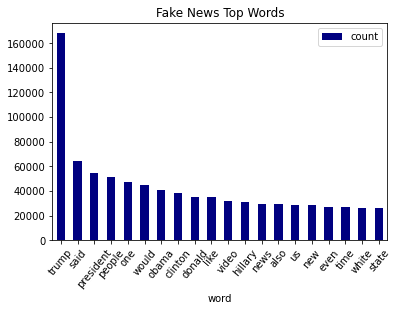

In [16]:

counts_df.iloc[:20].plot.bar(x='word', y='count', rot=0,color='navy')
plt.xticks(rotation=50)
plt.title('Fake News Top Words')
plt.show()

In [18]:
# load the data into rdd format
false_data = big_data[big_data['label']==1]
big_data_rdd = sc.parallelize(false_data.values.tolist())


# transformed to lowercase
big_data_lower = big_data_rdd.map(lambda f: ((f[0], f[2]), str.lower(f[1])))

# print(label_data_lower.take(5))

# remove numbers
big_data_no_number = big_data_lower.map(lambda f: (f[0], re.sub(r'\d+', '', f[1])))
# print(label_data_no_number.take(5))

# remove punctuation and split it into words
big_data_words = big_data_no_number.map(lambda f: (f[0], re.split(r'[^\w]+',f[1])))
big_data_words = big_data_words.map(lambda f: (f[0], [i for i in f[1] if i != '']))
# print(label_data_words.take(5))

big_data_no_stopwords = big_data_words.map(lambda f: (f[0], remove_stopwords(f[1])))

print(big_data_no_stopwords.take(5))

[((23481, 1), ['donald', 'trump', 'sends', 'embarrassing', 'new', 'year', 'eve', 'message', 'disturbing', 'donald', 'trump', 'sends', 'embarrassing', 'new', 'year', 'eve', 'message', 'disturbing', 'donald', 'trump', 'wish', 'americans', 'happy', 'new', 'year', 'leave', 'instead', 'give', 'shout', 'enemies', 'haters', 'dishonest', 'fake', 'news', 'media', 'former', 'reality', 'show', 'star', 'one', 'job', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'wish', 'friends', 'supporters', 'enemies', 'haters', 'even', 'dishonest', 'fake', 'news', 'media', 'happy', 'healthy', 'new', 'year', 'president', 'angry', 'pants', 'tweeted', 'great', 'year', 'america', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'wish', 'friends', 'supporters', 'enemies', 'haters', 'even', 'dishonest', 'fake', 'news', 'media', 'happy', 'healthy', 'new', 'year', 'great', 'year', 'america', 'donald', 'j', 'trump', 'realdonaldtrump', 'december', 'trump', 'tweet', 'went', 'welll', 'expect', 

In [19]:
words = big_data_no_stopwords.flatMap(lambda f: f[1])

pairs = words.map(lambda w: (w, 1))
counts = pairs.reduceByKey(lambda n1, n2: n1 + n2)

In [20]:

# Create a Spark DataFrame from a pandas DataFrame using Arrow
df = spark.createDataFrame(counts)

# Convert the Spark DataFrame back to a pandas DataFrame using Arrow
counts_df = df.select("*").toPandas()

/Users/local/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


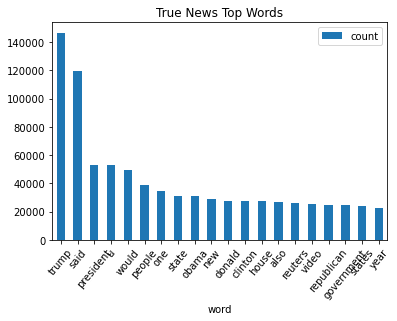

In [21]:
counts_df = counts_df.rename(columns={'_1': 'word', '_2': 'count'})
counts_df = counts_df.sort_values('count',ascending=False,ignore_index = True)

counts_df.iloc[:20].plot.bar(x='word', y='count', rot=0)
plt.xticks(rotation=50)
plt.title('True News Top Words')
plt.show()

## frequent co-occurance

In [34]:
false_data = big_data[big_data['label']==1].sample(5)

In [30]:
import nltk

In [35]:
def preprocessing(corpus):
    # initialize
    clean_text = []

    for row in corpus:
        # tokenize
        tokens = nltk.tokenize.word_tokenize(row)
        # lowercase
        tokens = [token.lower() for token in tokens]
        # isword
        tokens = [token for token in tokens if token.isalpha()]
        clean_sentence = ''
        clean_sentence = ' '.join(token for token in tokens)
        clean_text.append(clean_sentence)
        
    return clean_text
    
all_text = preprocessing(false_data['text'])

In [36]:
# sklearn countvectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Convert a collection of text documents to a matrix of token counts
cv = CountVectorizer(ngram_range=(1,1), stop_words = 'english')
# matrix of token counts
X = cv.fit_transform(all_text)
Xc = (X.T * X) # matrix manipulation
Xc.setdiag(0) # set the diagonals to be zeroes as it's pointless to be 1

In [37]:
names = cv.get_feature_names() # This are the entity names (i.e. keywords)
df = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)
df
df.to_csv('to_gephi.csv', sep = ',')

## Word Cloud 

In [9]:
mask = np.array(Image.open("mask.png"))
mask

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

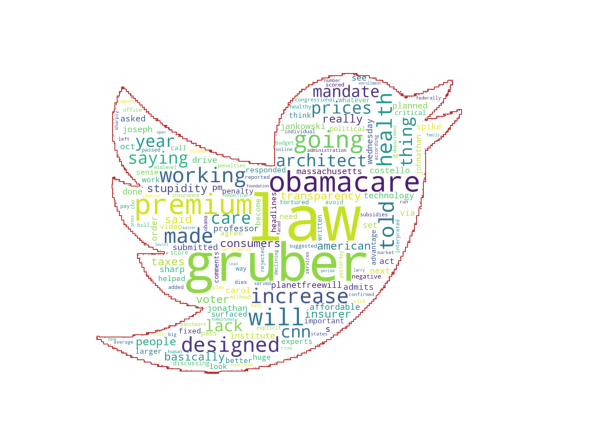

In [10]:
#Final word cloud after all the cleaning and pre-processing

comment_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for val in big_data.text: 

   # typecaste each val to string 
   val = str(val) 

   # split the value 
   tokens = val.split() 

# Converts each token into lowercase 
for i in range(len(tokens)): 
    tokens[i] = tokens[i].lower() 

for words in tokens: 
    comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            mask=mask,
            stopwords = stopwords, 
            contour_width=3, contour_color='firebrick',
            min_font_size = 10).generate(comment_words) 




# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [ ]:
wordcloud.to_file("wordcloud.png")